# Model

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root))

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from config.features import CAT_FEATURES

# sklearn utilities
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold

from imblearn.pipeline import Pipeline as ImbalancePipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.ensemble import RUSBoostClassifier

from lightgbm import LGBMClassifier

# sklearn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
train = pd.read_parquet('../data/train.parquet')
sample_train = train.groupby('isFraud', group_keys=False)[train.columns].apply(lambda x: x.sample(frac=0.1, random_state=42))

print(train.shape)
print(sample_train.shape)

(590540, 253)
(59054, 253)


In [4]:
X = sample_train.drop(columns=['isFraud'])
y = sample_train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

print(X_train.shape)
print(y_train.shape)

(39566, 252)
(39566,)


In [5]:
del train, sample_train

### Pre-processing

In [6]:
X_train = X_train.replace([np.inf, -np.inf], -999)
X_test = X_test.replace([np.inf, -np.inf], -999)

In [7]:
X_train[CAT_FEATURES] = X_train[CAT_FEATURES].astype(str)
X_test[CAT_FEATURES] = X_test[CAT_FEATURES].astype(str)

In [8]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [col for col in X_train.columns if col not in CAT_FEATURES]),
        ('cat', categorical_transformer, CAT_FEATURES)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [9]:
del X_train, X_test

#### Model Selection

In [10]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_transformed, y_train)

y_pred = decision_tree.predict(X_test_transformed)

In [11]:
train_score = decision_tree.score(X_train_transformed, y_train)
test_score = decision_tree.score(X_test_transformed, y_test)

print("Train score: {}".format(train_score))
print("Test score: {}".format(test_score))

Train score: 1.0
Test score: 0.9503284072249589


In [12]:
confusion_matrix(y_test, y_pred)

array([[18258,   548],
       [  420,   262]])

In [13]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9503284072249589
Precision: 0.3234567901234568
Recall: 0.3841642228739003
F1 Score: 0.3512064343163539


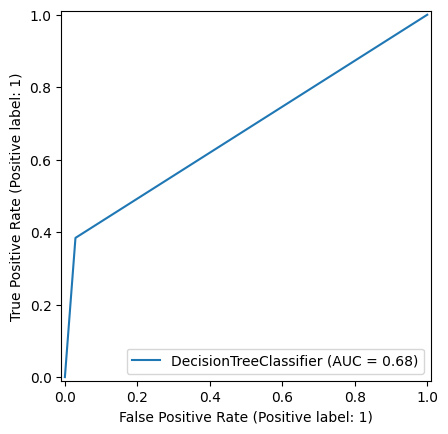

In [14]:
RocCurveDisplay.from_estimator(decision_tree, X_test_transformed, y_test)

#### Cross Validation

In [46]:
np.random.seed(42)

results = {}
results['DT'] = [roc_auc_score(y_test, y_pred)]

k_folds = 5
cv = StratifiedKFold(n_splits=k_folds, shuffle=True)

models = {
    'GB': GradientBoostingClassifier(),
    'AB': AdaBoostClassifier(algorithm="SAMME"),
    'RF': RandomForestClassifier(),
    'BC': BaggingClassifier(),
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='roc_auc')
    results[name] = scores

    print(f'{name}: {scores.mean()} ({scores.std()})')

GB: 0.876785256767614 (0.009743917236243198)
RF: 0.869581098167059 (0.009629903692757479)
BC: 0.8012451733097639 (0.01550170637901781)
AB: 0.8549021577504435 (0.00849810041486483)


In [47]:
results

{'DT': [np.float64(0.6775122932938045)],
 'GB': array([0.89114651, 0.8612056 , 0.87771656, 0.88045298, 0.87340462]),
 'RF': array([0.86128311, 0.88478645, 0.87677692, 0.86501807, 0.86004093]),
 'BC': array([0.78463934, 0.82963637, 0.80239101, 0.79894968, 0.79060946]),
 'AB': array([0.83849835, 0.85737746, 0.85652278, 0.86299365, 0.85911855])}

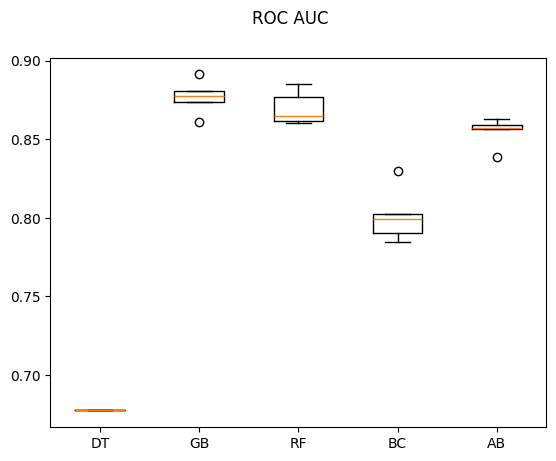

In [48]:
fig = plt.figure() 
fig.suptitle('ROC AUC') 
ax = fig.add_subplot(111) 
plt.boxplot(results.values()) 
ax.set_xticklabels(results.keys()) 
plt.show()

#### Resampling Methods

In [49]:
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

scores = cross_val_score(RandomForestClassifier(random_state=42), X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print(f'UNDER_RF: {scores.mean()} ({scores.std()})')

results['UNDER_RF'] = scores

UNDER_RF: 0.8763413149346816 (0.015362101549511262)


In [50]:
rus_boost = RUSBoostClassifier(random_state=42)

scores = cross_val_score(rus_boost, X_train_transformed, y_train, cv=cv, scoring='roc_auc')
print(f'RUSB: {scores.mean()} ({scores.std()})')

results['RUSB'] = scores

RUSB: 0.7243392309533518 (0.061248328400061954)


In [51]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

scores = cross_val_score(LGBMClassifier(random_state=42, verbose=-1), X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print(f'SMOTE_LGBM: {scores.mean()} ({scores.std()})')

results['SMOTE_LGBM'] = scores

SMOTE_LGBM: 0.9967084172291539 (0.0003257718193240505)


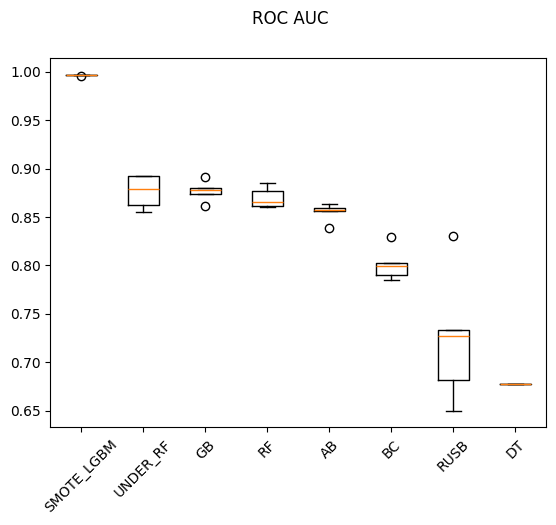

In [53]:
sorted_results = dict(sorted(results.items(), key=lambda x: np.median(x[1]), reverse=True))

fig = plt.figure() 
fig.suptitle('ROC AUC') 
ax = fig.add_subplot(111) 
plt.boxplot(sorted_results.values()) 
ax.set_xticklabels(sorted_results.keys(), rotation=45) 
plt.show()